In [2]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F
import torch.optim as optim
import tqdm



In [21]:
import os
 
path = 'EuroSAT_RGB'
dir_list = os.listdir(path)
convert_tensor = transforms.ToTensor()

images = []
labels = []

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

for label in dir_list:
    path = 'EuroSAT_RGB/'+ label + '/'
    dir_list = os.listdir(path)
    for file in dir_list:
        img = Image.open(path+file)
        img_tensor = transform(img)
        images.append(img_tensor)
        labels.append(label)



In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

label_to_index = {}
label_to_index = {label: index for index, label in enumerate(set(labels))}

label_indices = []

for label in labels:
    label_indices.append(label_to_index[label])

data_array = np.array(images)
labels_array = np.array(label_indices)

train_data, test_data, train_labels, test_labels = train_test_split(data_array, labels_array, test_size=0.2, random_state=1)




/var/folders/hg/kqg69xz568l28vnvcx6x09hh0000gn/T/ipykernel_47485/2904071098.py:12: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_array = np.array(images)
/var/folders/hg/kqg69xz568l28vnvcx6x09hh0000gn/T/ipykernel_47485/2904071098.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(images)


In [23]:
train_data_tuple = []
test_data_tuple = []


for i in range(len(train_data)):
    train_data_tuple.append(tuple([train_data[i],train_labels[i]]))

for i in range(len(test_data)):
    test_data_tuple.append(tuple([test_data[i],test_labels[i]]))


trainloader = torch.utils.data.DataLoader(train_data_tuple, batch_size=64,shuffle=True, num_workers=2 )
testloader = torch.utils.data.DataLoader(test_data_tuple, batch_size=64,shuffle=True, num_workers=2 )


In [19]:

# for i in range(1,5):
#     print(train_labels[i])
#     plt.imshow(train_data[i].permute(1, 2, 0))
#     plt.show()


In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(28800, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=28800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [36]:
num_epochs = 1

#Version1
# for epoch in range(num_epochs):
#     for i in range (0,len(train_data)):
#         lbl = torch.tensor([train_labels[i]])
#         img = train_data[i].unsqueeze(0)


#         outputs = net(img)
#         loss = criterion(outputs, lbl)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()


#Version2


# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()  # Clear gradients
        output = net(data)    # Forward pass
        loss = criterion(output, target)  # Calculate loss
        loss.backward()       # Backpropagation
        optimizer.step()      # Update model parameters
        running_loss += loss.item()





 


ValueError: only one element tensors can be converted to Python scalars

In [51]:
predicted_labels = []
actual_labels = []

with torch.no_grad():
        net.eval()  # Set the model to evaluation mode
        for val_data, val_target in testloader:
            val_output = net(val_data)
            _, predicted = torch.max(val_output, 1)
            #print('Predicted:', ' '.join('%d' % predicted[j] for j in range(8)))
            #print('Actual:', ' '.join('%d' % val_target[j] for j in range(8)))
            predicted_labels.extend(predicted.tolist())
            actual_labels.extend(val_target.tolist())





0.8190740740740741


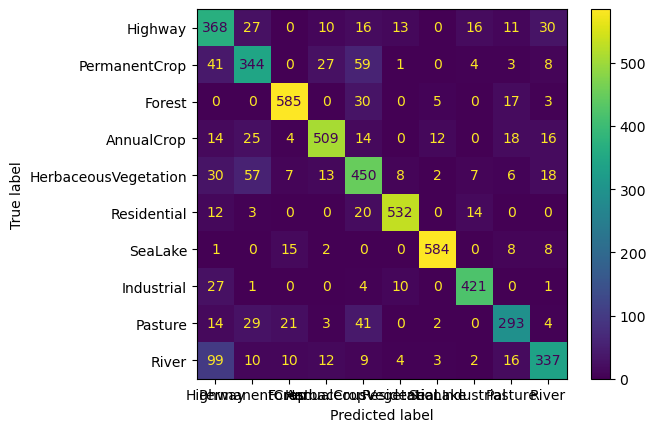

In [53]:
import sklearn.metrics as mt

accuracy = mt.accuracy_score(y_pred=(predicted_labels),y_true=actual_labels)

print(accuracy)

mtx = mt.confusion_matrix(y_pred=(predicted_labels),y_true=actual_labels)

disp = mt.ConfusionMatrixDisplay(confusion_matrix = mtx, display_labels=label_to_index.keys())

disp.plot()